'mental' notes in case there's a bad model:
* reexamine waterfront nulls
* reexamine outliers
* scale zero-inflated features

# Import Data

In [374]:
# set up environment with imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
plt.style.use('seaborn')
pd.set_option('display.max_columns', None)
import datetime as dt
import pickle

import warnings
warnings.filterwarnings("ignore")

In [375]:
# import housing data to dataframe and preview
df = pd.read_csv('../databases/kc-house-data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Clean Data

## Investigate Duplicates
Let's see if there are any duplicates and what it means.

The first thing we should do is just drop any complete duplicates because there shouldn't be any completely identical observations.

In [376]:
# check for complete duplicates
df.duplicated().sum()

0

No complete duplicates. So, now we'll look more closely at individual fields. Let's check if there are any columns that categorically should not have duplicates.

In [377]:
# print out list of columns
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Everything seems to check out here. If there are some duplicate issues, they aren't immediately obvious.

`id` might seem like it shouldn't have duplicates but it's possible the same house was sold more than once.

In [378]:
# check one of the id's to see if it was sold on different dates
df[df['id'] == 795000620]['date']

17588     9/24/2014
17589    12/15/2014
17590     3/11/2015
Name: date, dtype: object

## Investigate Placeholders
We should address placeholders before official nulls because placeholders often represent nulls.

In [379]:
# look for weird values
for col in df.columns:
    display(df[col].value_counts())

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
11/2/2014      1
5/27/2015      1
8/3/2014       1
2/15/2015      1
8/30/2014      1
Name: date, Length: 372, dtype: int64

350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

0.0    19075
1.0      146
Name: waterfront, dtype: int64

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1245.0        1
792.0         1
3500.0        1
1481.0        1
283.0         1
Name: sqft_basement, Length: 304, dtype: int64

2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

47.6624    17
47.5491    17
47.5322    17
47.6846    17
47.6711    16
           ..
47.2785     1
47.4162     1
47.3870     1
47.2313     1
47.2715     1
Name: lat, Length: 5033, dtype: int64

-122.290    115
-122.300    111
-122.362    104
-122.291    100
-122.372     99
           ... 
-121.403      1
-121.804      1
-121.726      1
-121.895      1
-121.893      1
Name: long, Length: 751, dtype: int64

1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64

Almost everything looks normal.

But `sqft_basement` has some `?` values that we should replace with nulls.

In [380]:
# replace '?' with null values
df['sqft_basement'].replace('?', np.nan, inplace=True)

In [381]:
# admire our handywork
df['sqft_basement'].value_counts(dropna=False)

0.0       12826
NaN         454
600.0       217
500.0       209
700.0       208
          ...  
374.0         1
295.0         1
1852.0        1
65.0          1
1548.0        1
Name: sqft_basement, Length: 304, dtype: int64

## Investigate Nulls

In [382]:
# get number nulls by feature and put it into a df
nulls = df.isna().sum().reset_index()

# view
display(nulls)

,index,0
0,id,0
1,date,0
2,price,0
3,bedrooms,0
4,bathrooms,0
5,sqft_living,0
6,sqft_lot,0
7,floors,0
8,waterfront,2376
9,view,63


In [383]:
# list percentage nulls by feature (only greater than 0)
nulls['percentage'] = nulls[0] / len(df) * 100
display(nulls[nulls['percentage'] > 0])

,index,0,percentage
8,waterfront,2376,11.001528
9,view,63,0.291707
13,sqft_basement,454,2.102144
15,yr_renovated,3842,17.789508


Not too shabby. Most features don't have any nulls.

### Address `view` nulls

`view` has less than 1%, so, we can probably just drop those rows but let's make sure there's no pattern to the nulls.

In [384]:
# get a df with just the view nulls
view_isna = df[df['view'].isna()]

# see the percentage zipcodes represented in nulls
print('***** percent zipcodes represented in view nulls *****')
display(view_isna['zipcode'].nunique() / df['zipcode'].nunique())

# calculate the percentage dropped for each zip
percent_loss = view_isna['zipcode'].value_counts() / df['zipcode'].value_counts()

# find how many will be different by more than 1%
print('***** zipcodes changed by more than 1%  by dropping *****')
display((percent_loss > .01).sum())

# find how many zips will be impacted by more than 1.3%
print('***** zipcodes changed by more than 1.3%  by dropping *****')
display((percent_loss > .013).sum())

***** percent zipcodes represented in view nulls *****


0.5571428571428572

***** zipcodes changed by more than 1%  by dropping *****


3

***** zipcodes changed by more than 1.3%  by dropping *****


0

3 of the zipcodes will be impacted more than 1% but none will be impacted more than 1.5%. So, I feel okay about dropping them from a numerical perspective.

Let's do one last sanity check by actually looking at the feature to get to know it better.

In [385]:
# print view feature
df['view'].value_counts(normalize=True, dropna=False)

0.0    0.899292
2.0    0.044312
3.0    0.023522
1.0    0.015280
4.0    0.014678
NaN    0.002917
Name: view, dtype: float64

On second thought, I think I'll just impute the median. The views don't seem to have particuarly compelling data; so, why lose valuable data in other columns over that? For reference, the column definition is: **view** - Has been viewed

In [386]:
# let's make a function to compare the imputed median histogram 
# with the original data
def compare_impute_hist(df, col):
    """Plots a histogram of col with and without imputed median on nulls.
    
    Used to compare the distribution shape before and after median imputation.
    
    Keyword arguments:
    df -- Pandas dataframe
    col -- Feature name string
    """
    df[col].hist(bins='auto')
    plt.show()
    df[col].fillna(df[col].median()).hist(bins='auto')
    plt.show()

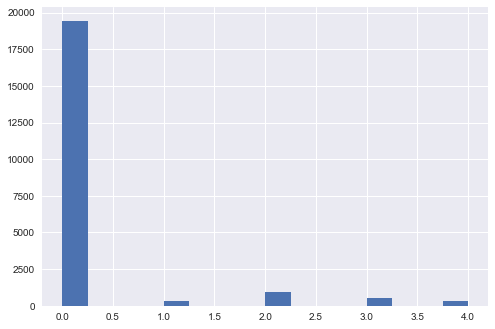

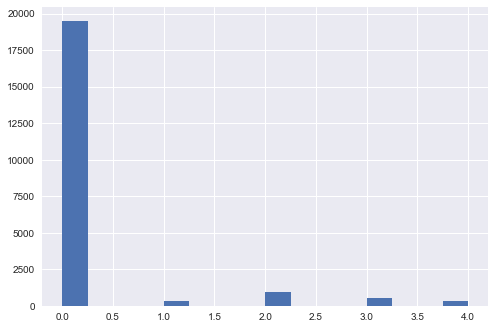

0.0

In [387]:
# let's see what both histograms look like
compare_impute_hist(df, 'view')
# print out the imputation value
df['view'].median()

Not feeling terrible about that difference. Let's use it.

In [388]:
# We ended up using this snippet every time.
# So, we very non-generalizably threw it into a function
def impute_median_with_comparison(df, col):
    """impute median to col in df and compare value_counts head before and after
    
    Keyword arguments:
    df -- Pandas dataframe
    col -- Feature name string
    """
    # print original for comparison
    display(df[col].value_counts(dropna=False, normalize=True).head())
    # impute median
    df[col].fillna(df[col].median(), inplace=True)

    # admire our handywork
    display(df[col].value_counts(dropna=False, normalize=True).head())

In [389]:
# impute median
impute_median_with_comparison(df, 'view')

0.0    0.899292
2.0    0.044312
3.0    0.023522
1.0    0.015280
4.0    0.014678
Name: view, dtype: float64

0.0    0.902209
2.0    0.044312
3.0    0.023522
1.0    0.015280
4.0    0.014678
Name: view, dtype: float64

### Address `sqft_basement` Nulls
I already examined `sqft_basement` and I think I should impute using median.

Let's see what the histograms look like, though.

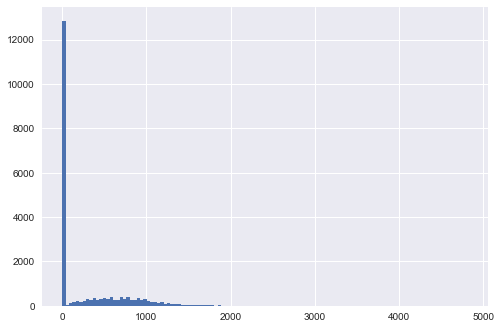

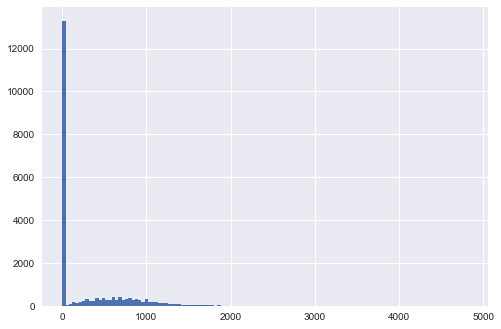

0.0

In [390]:
# convert basement to float
df['sqft_basement'] = df['sqft_basement'].astype(dtype='float')
# let's see what both histograms look like
compare_impute_hist(df, 'sqft_basement')
# print out imputation value
display(df['sqft_basement'].median())

Other than this having some outliers, those appear to be unrelated to the median value. So, we can impute.

In [391]:
# impute median
impute_median_with_comparison(df, 'sqft_basement')

0.0      0.593879
NaN      0.021021
600.0    0.010048
500.0    0.009677
700.0    0.009631
Name: sqft_basement, dtype: float64

0.0      0.614900
600.0    0.010048
500.0    0.009677
700.0    0.009631
800.0    0.009307
Name: sqft_basement, dtype: float64

### Address `waterfront` Nulls
Let's begin by looking at the actual feature this time and see if we can avoid any unnecessary hardship

In [392]:
# examine waterfront
df['waterfront'].value_counts(dropna=False, normalize=True)

0.0    0.883225
NaN    0.110015
1.0    0.006760
Name: waterfront, dtype: float64

`waterfront` is actually quite similar to `view` in the fact that the vast majority of observations are equal to 0. I'm more hesitant about imputing 11% of the observations. However, as with `view`, `waterfront` does not appear to be that powerful of a feature compared to others because of a lack of variation; so, I'll impute using the median and if my model demands `waterfront` or I hit a wall, I can come back later and perhaps try another method. For reference, the definition for `waterfront`: **waterfront** - House which has a view to a waterfront

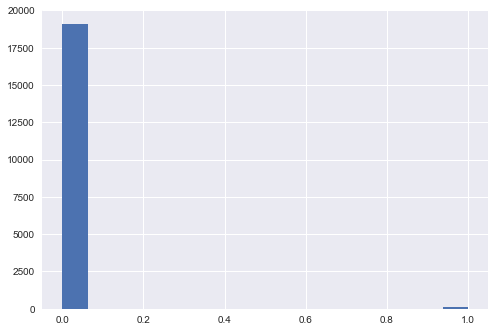

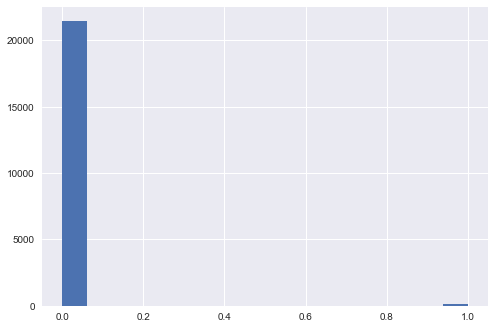

0.0

In [393]:
# let's see what both histograms look like
compare_impute_hist(df, 'waterfront')

# print out imputation value
df['waterfront'].median()

Again, imputation value is 0 and doesn't appear to make a significant difference to the distribution.

In [394]:
# impute median
impute_median_with_comparison(df, 'waterfront')

0.0    0.883225
NaN    0.110015
1.0    0.006760
Name: waterfront, dtype: float64

0.0    0.99324
1.0    0.00676
Name: waterfront, dtype: float64

### Address `yr_renovated` Nulls
Lastly, let's look at `yr_renovated`, which has the largest percentage of nulls at nearly 18%

In [395]:
# examine yr_renovated
df['yr_renovated'].value_counts(dropna=False, normalize=True)

0.0       0.787656
NaN       0.177895
2014.0    0.003380
2003.0    0.001435
2013.0    0.001435
            ...   
1944.0    0.000046
1948.0    0.000046
1976.0    0.000046
1934.0    0.000046
1953.0    0.000046
Name: yr_renovated, Length: 71, dtype: float64

This is a little more tricky because it's one part continuous and one part categorical. So, it may make sense to jump ahead and do some feature engineering at this point. 

Let's have a look at the histogram to see how we may want to bin these values into categories that both make sense and are full enough to have statistical value.

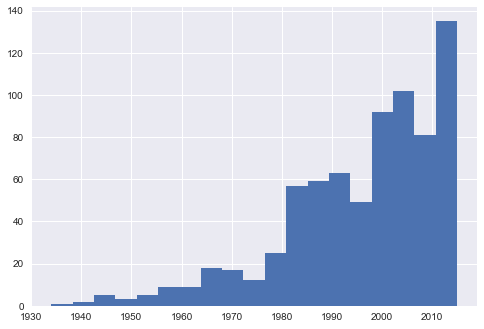

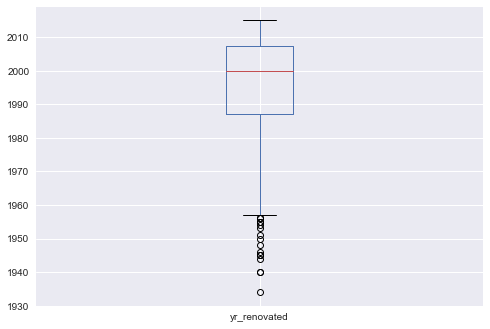

count     744.000000
mean     1995.928763
std        15.599946
min      1934.000000
25%      1987.000000
50%      2000.000000
75%      2007.250000
max      2015.000000
Name: yr_renovated, dtype: float64

In [396]:
# get yr_renovated excluding 0's
df_yr_ren_no_zeroes = df[df['yr_renovated'] > 0]

# plot histogram
df_yr_ren_no_zeroes['yr_renovated'].hist(bins='auto')
plt.show()

# plot boxplot
df_yr_ren_no_zeroes.boxplot('yr_renovated')
plt.show()

# get some more info
df_yr_ren_no_zeroes['yr_renovated'].describe()

We can't easily bin the data without imputing some values. So, we're going to take the same tack as with the others using median imputation.

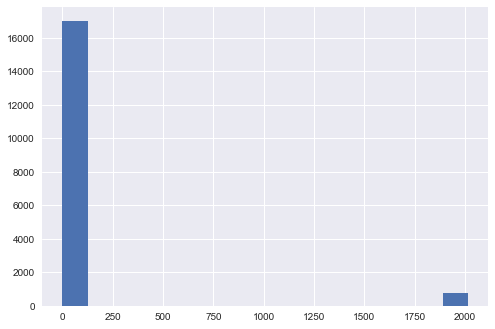

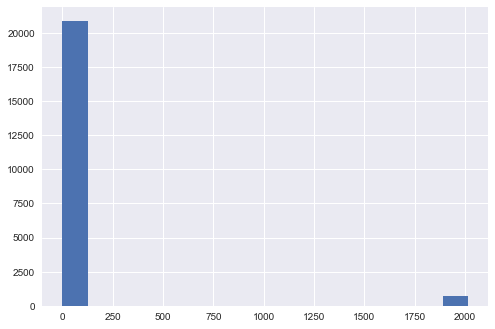

0.0

In [397]:
# let's see what both histograms look like
compare_impute_hist(df, 'yr_renovated')

# print imputation value
df['yr_renovated'].median()

This one feels a little different because of the sheer number of imputations. However, I think we'll just keep this in the back of our minds for now because median imputation is simpler and faster than KNN and imputation is almost always preferable to dropping (since dropping assumes randomness in nulls which often introduces bias). We could potentially engineer this feature a bit if we find some overall problems but, otherwise, I think we'll forge ahead and impute median.

In [398]:
# impute median
impute_median_with_comparison(df, 'yr_renovated')

0.0       0.787656
NaN       0.177895
2014.0    0.003380
2003.0    0.001435
2013.0    0.001435
Name: yr_renovated, dtype: float64

0.0       0.965551
2014.0    0.003380
2003.0    0.001435
2013.0    0.001435
2007.0    0.001389
Name: yr_renovated, dtype: float64

## Check Data Types
Now that we've gotten rid of null values, we can step back and make sure the data types all make sense.

In [399]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB


* `date` should probably be datetime type
* `bathrooms` should be examined
* `floors` should be examined
* `grade` should be examined
* `yr_renovated` should be examined for fractions

### Convert `date` to datetime type

In [400]:
# let's take a look
df['date'].value_counts()

6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
11/2/2014      1
5/27/2015      1
8/3/2014       1
2/15/2015      1
8/30/2014      1
Name: date, Length: 372, dtype: int64

It seems like they follow the same format. Let's see how conversion goes.

In [401]:
# convert date to datetime type
df['date'] = df['date'].astype('datetime64')

# admire our handywork
df['date'].head()

0   2014-10-13
1   2014-12-09
2   2015-02-25
3   2014-12-09
4   2015-02-18
Name: date, dtype: datetime64[ns]

Huzzah! Moving on.

Let's create some other features from `date` as well.

In [402]:
# create new sale date ordinal features
df['yr_sold'] = df['date'].dt.year
df['day_of_yr_sold'] = df['date'].dt.dayofyear
df['month_sold'] = df['date'].dt.month

# admire our handywork
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,day_of_yr_sold,month_sold
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,2014,286,10
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014,343,12
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,2015,56,2
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,2014,343,12
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2015,49,2


### Examine `bathrooms`

In [403]:
# examine bathrooms
df['bathrooms'].value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

Seems reasonable. Moving on.

### Examine `floors`

In [404]:
# examine floors
df['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

Not super clear what that looks like but I'm told it's a thing; so, it all seems reasonable. Moving on.

### Examine `grade`

Definition

**grade** - overall grade given to the housing unit, based on King County grading system

In [405]:
# examine grade
df['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

If it's a grading system, it can be as arbitrary as they like. So, we'll take their word for it.

### Examine `yr_renovated`

In [406]:
# look to see if there are any weird values
df['yr_renovated'].unique()

array([   0., 1991., 2002., 2010., 1992., 2013., 1994., 1978., 2005.,
       2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990., 1988.,
       1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989., 2004.,
       1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971., 1979.,
       1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008., 1968.,
       2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955., 1982.,
       1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957., 1959.,
       1960., 1967., 1965., 1934., 1972., 1944., 1958.])

No weird values. It probably doesn't need to be a float, though; so, let's change it to int to keep it lighter.

In [407]:
# convert yr_renovated to int64
df['yr_renovated'] = df['yr_renovated'].astype('int64')

# admire our handywork
df['yr_renovated'].dtype

dtype('int64')

In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 24 columns):
id                21597 non-null int64
date              21597 non-null datetime64[ns]
price             21597 non-null float64
bedrooms          21597 non-null int64
bathrooms         21597 non-null float64
sqft_living       21597 non-null int64
sqft_lot          21597 non-null int64
floors            21597 non-null float64
waterfront        21597 non-null float64
view              21597 non-null float64
condition         21597 non-null int64
grade             21597 non-null int64
sqft_above        21597 non-null int64
sqft_basement     21597 non-null float64
yr_built          21597 non-null int64
yr_renovated      21597 non-null int64
zipcode           21597 non-null int64
lat               21597 non-null float64
long              21597 non-null float64
sqft_living15     21597 non-null int64
sqft_lot15        21597 non-null int64
yr_sold           21597 non-null int64
day_of_y

### Export Semi-Cleaned

In [409]:
# pickle results
with open('../databases/df-semi-cleaned.pickle', 'wb') as f:
    # Pickle the 'df' dataframe using the highest protocol available.
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

## Engineer Some Features

Thinking about engineering some fields defined by the difference between when the house was sold and when it was renovated or built. First, let's see what `year_sold` looks like to see if there's much variation in it.

In [410]:
df['yr_sold'].describe()

count    21597.000000
mean      2014.322962
std          0.467619
min       2014.000000
25%       2014.000000
50%       2014.000000
75%       2015.000000
max       2015.000000
Name: yr_sold, dtype: float64

Because there isn't much variation in `yr_sold`, there won't be enough variation in difference-based features to distinguish them from the `yr_renovated` and `yr_built` features.

What about messing with `yr_renovated`?

count     744.000000
mean     1995.928763
std        15.599946
min      1934.000000
25%      1987.000000
50%      2000.000000
75%      2007.250000
max      2015.000000
Name: yr_renovated, dtype: float64

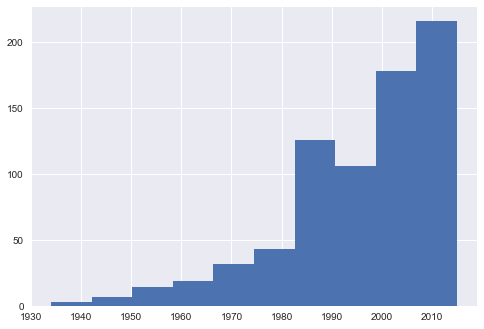

In [411]:
display(df[df['yr_renovated'] > 0]['yr_renovated'].hist())
df[df['yr_renovated'] > 0]['yr_renovated'].describe()

In [412]:
df['yr_renovated'].value_counts()

0       20853
2014       73
2003       31
2013       31
2007       30
        ...  
1976        1
1953        1
1951        1
1946        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

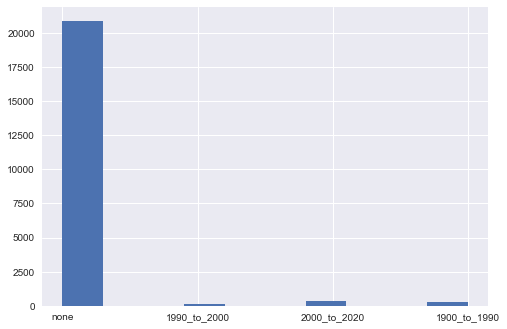

In [413]:
# Define bins based on statistics
yr_built_bins = [-1, 1900, 1990, 2000, 2020]
yr_built_labels = ['none', '1900_to_1990', '1990_to_2000', '2000_to_2020']

# Map to bins using pd.cut()
pd.cut(df['yr_renovated'], bins = yr_built_bins, labels = yr_built_labels).hist()

## Examine Outliers

Let's have a look at some of the most extreme outliers from our numerical data.

In [414]:
# get numerical data
df_num = df._get_numeric_data()

# print extreme outliers
for col in df_num.columns:
    print(col)
    display(df_num[(df_num[col] > df_num[col].quantile(.9995)) | (df_num[col] < df_num[col].quantile(.0005))][col])

id


1714     9839300875
2494        1000102
2495        1000102
3197        3800008
3257     9842300485
3553        3600057
4329        6200017
4675     9839301055
4817     9839301060
6729        1200019
7614     9842300540
8404        1200021
8800        2800031
11642    9842300036
13015    9839301165
14236    9839300775
15937    9900000190
16701       7200080
16723    9842300095
18506       3600072
20963    9895000040
21047       5200087
Name: id, dtype: int64

price


465        80000.0
1162     5110000.0
1313     5300000.0
1446     5350000.0
2139       82500.0
2624     4500000.0
3763       84000.0
3910     7060000.0
4407     5570000.0
5860       89000.0
7245     7700000.0
8085     4670000.0
8267       82000.0
8629     4490000.0
9245     6890000.0
10242      85000.0
12358    4210000.0
13743      86500.0
15279      78000.0
16184      81000.0
16700      85000.0
18453      83000.0
Name: price, dtype: float64

bedrooms


4092      9
4231      9
6073      9
8537      9
8748     11
13301    10
15147    10
15856    33
16830     9
18428     9
19239    10
Name: bedrooms, dtype: int64

bathrooms


2259     0.50
4020     6.75
7245     8.00
8085     6.75
8537     7.50
9245     7.75
10413    0.50
11662    0.50
12029    0.50
12764    8.00
14542    6.25
18288    6.25
20562    6.50
21490    6.50
Name: bathrooms, dtype: float64

sqft_living


465        430
860        380
1162      8010
1166       440
1446      8000
3910     10040
4407      9200
7245     12050
8085      9640
8614       410
9245      9890
11488      420
12063      470
12764    13540
13398     7880
14452      420
14542     8670
15234      470
15367      370
18038      460
18288     8020
21316      390
Name: sqft_living, dtype: int64

sqft_lot


547          649
1717     1651359
3449         609
3945      982998
4348         649
4437      982278
4536      843309
5821         572
6685      920423
7070      881654
7206         676
7582         600
7640     1074218
7762     1024068
9705      871200
15729        520
17305    1164794
19646        651
20436     871200
20588        635
21503        675
21536        638
Name: sqft_lot, dtype: int64

floors


10066    3.5
11582    3.5
14871    3.5
15410    3.5
18462    3.5
20292    3.5
20756    3.5
Name: floors, dtype: float64

waterfront


Series([], Name: waterfront, dtype: float64)

view


Series([], Name: view, dtype: float64)

condition


Series([], Name: condition, dtype: int64)

grade


3220    3
Name: grade, dtype: int64

sqft_above


465       430
860       380
1166      440
1446     6720
3910     7680
7245     8570
8614      410
9245     8860
11488     420
11859    7420
12063     470
12764    9410
13398    7880
14452     420
15234     470
15367     370
16759    6660
18038     460
18288    8020
18579    7320
19842    7850
21316     390
Name: sqft_above, dtype: int64

sqft_basement


4407     3000.0
5044     2850.0
6622     2720.0
7028     2730.0
7245     3480.0
8085     4820.0
10074    3260.0
12764    4130.0
15035    2610.0
15468    3500.0
21328    2810.0
Name: sqft_basement, dtype: float64

yr_built


Series([], Name: yr_built, dtype: int64)

yr_renovated


Series([], Name: yr_renovated, dtype: int64)

zipcode


Series([], Name: zipcode, dtype: int64)

lat


306      47.7776
401      47.1775
591      47.1803
2755     47.1776
3292     47.1559
3692     47.7772
6049     47.7775
6808     47.7775
7712     47.1764
9201     47.1808
12261    47.1776
12546    47.7772
12656    47.1647
12946    47.7775
12993    47.1622
13451    47.1795
15585    47.1593
15752    47.7776
15838    47.7774
17450    47.7776
18011    47.7772
Name: lat, dtype: float64

long


1166    -122.512
2587    -121.359
2925    -121.315
2962    -122.514
4199    -121.315
4607    -122.509
6083    -121.352
6096    -122.511
8270    -122.511
9289    -122.515
9436    -122.509
10084   -121.352
10886   -121.319
11171   -122.506
11973   -122.507
13059   -121.316
13236   -121.321
13873   -122.519
14601   -121.325
16927   -121.364
19634   -121.364
Name: long, dtype: float64

sqft_living15


1122     5790
1528     5600
1918      620
5446     5790
6065      700
10362    6110
11859    5610
12094     460
12700    5500
13428     399
16416    5790
17272     460
17873     620
18035     670
19842    6210
19882     700
19997     690
20547    5790
20765     690
20814    5790
21524    5790
Name: sqft_living15, dtype: int64

sqft_lot15


513         660
1717     425581
3797     434728
6685     411962
8655     438213
9705     871200
13451    560617
15606    392040
17645    386812
19141    422967
19653       651
19711       750
20079       755
20436    858132
20715       750
20733       659
20891       748
20999       748
21093       750
21121       757
21415    392040
21520       750
Name: sqft_lot15, dtype: int64

yr_sold


Series([], Name: yr_sold, dtype: int64)

day_of_yr_sold


Series([], Name: day_of_yr_sold, dtype: int64)

month_sold


Series([], Name: month_sold, dtype: int64)

None of these seem so horrendously outlandish that I'm not willing to move forward with them. If my model doesn't work, let's keep a mental note to come back and evaluate this.

## Log-Transformation (Normalization)

This is where we'll see if we can make any continuous variables more normal. A nice heuristic for continuous variables are features with a high number of unique values.

In [415]:
# list unique values by feature
df.nunique()

id                21420
date                372
price              3622
bedrooms             12
bathrooms            29
sqft_living        1034
sqft_lot           9776
floors                6
waterfront            2
view                  5
condition             5
grade                11
sqft_above          942
sqft_basement       303
yr_built            116
yr_renovated         70
zipcode              70
lat                5033
long                751
sqft_living15       777
sqft_lot15         8682
yr_sold               2
day_of_yr_sold      356
month_sold           12
dtype: int64

Let's use 100 as our baseline since `yr_renovated` and `zipcode` should not be continuous (imho) but `sqft_basement` should be continuous.

In [416]:
# select continuous data
df_cont = df.loc[:, (df.nunique() > 100)]

# admire our handywork
df_cont.head(1)

,id,date,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,day_of_yr_sold
0,7129300520,2014-10-13,221900.0,1180,5650,1180,0.0,1955,47.5112,-122.257,1340,5650,286


In [417]:
# drop a few more that snuck through
non_cont = ['id', 'date', 'yr_built', 'lat', 'long', 'day_of_yr_sold']
df_cont = df_cont.drop(columns=non_cont)

# admire our handywork
df_cont.head(1)

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,221900.0,1180,5650,1180,0.0,1340,5650


Now let's have a gander at the distributions of our continuous features.

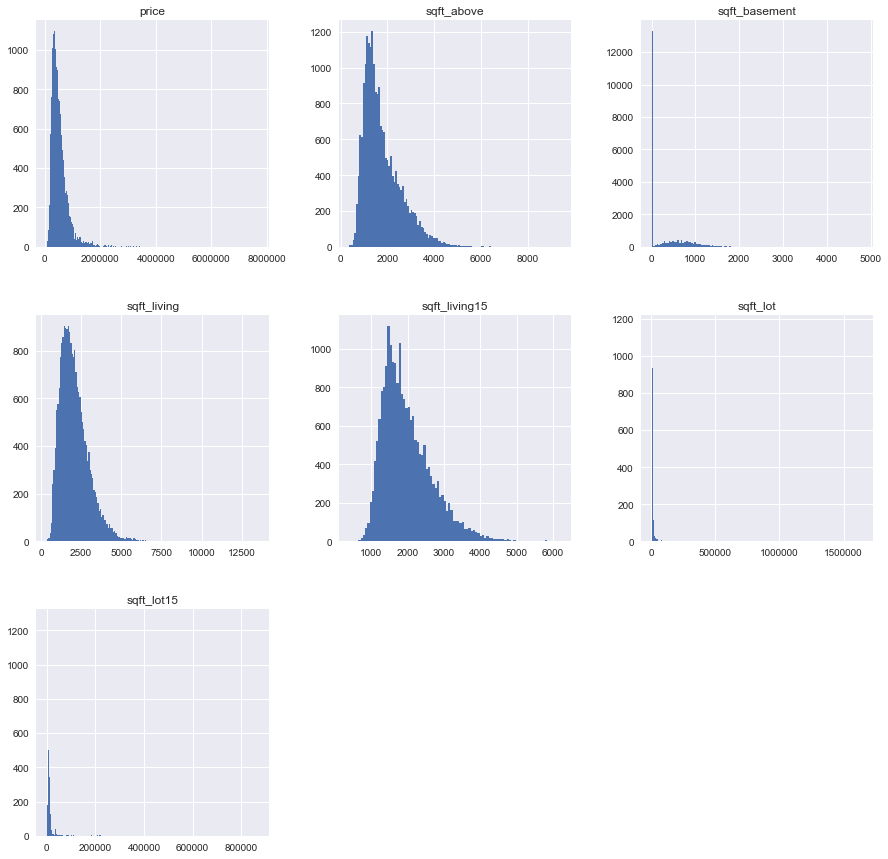

In [418]:
# plot histograms for continuous features
df_cont.hist(figsize=[15,15], bins='auto');

Let's get rid of the zero-inflated features, too, since they won't be easy to tweak into a normal shape. They're pseudo-categorical.

In [419]:
# drop the zero-inflated features
zero_inf = ['sqft_lot', 'sqft_lot15', 'sqft_basement']
df_cont = df_cont.drop(columns=zero_inf)

# admire our handywork
df_cont.head(1)

,price,sqft_living,sqft_above,sqft_living15
0,221900.0,1180,1180,1340


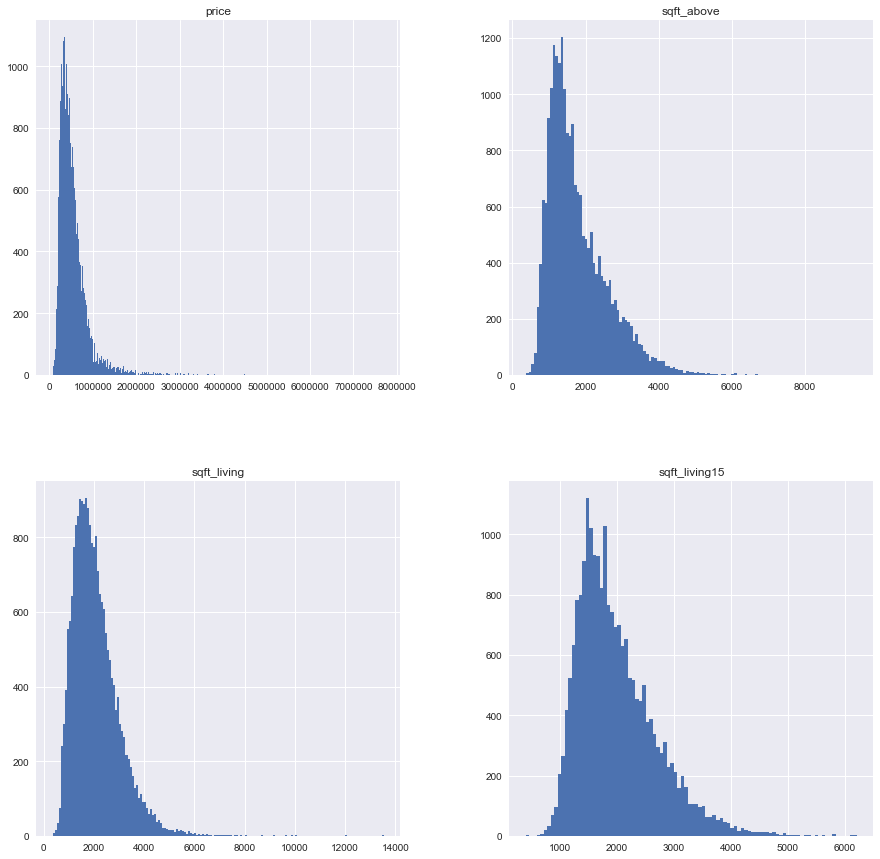

In [420]:
# plot histograms for continuous features again
df_cont.hist(figsize=[15,15], bins='auto');

In [421]:
# get new log transform names
log_names = [f'{column}_log' for column in df_cont.columns]

# log transform continuous features
df_log = np.log(df_cont)

# add column names for the log transformed data
df_log.columns = log_names

In [422]:
# admire
df_log.columns

Index(['price_log', 'sqft_living_log', 'sqft_above_log', 'sqft_living15_log'], dtype='object')

In [423]:
# check for infinite values due to log(0)
df_log.isin([-np.inf]).sum()

price_log            0
sqft_living_log      0
sqft_above_log       0
sqft_living15_log    0
dtype: int64

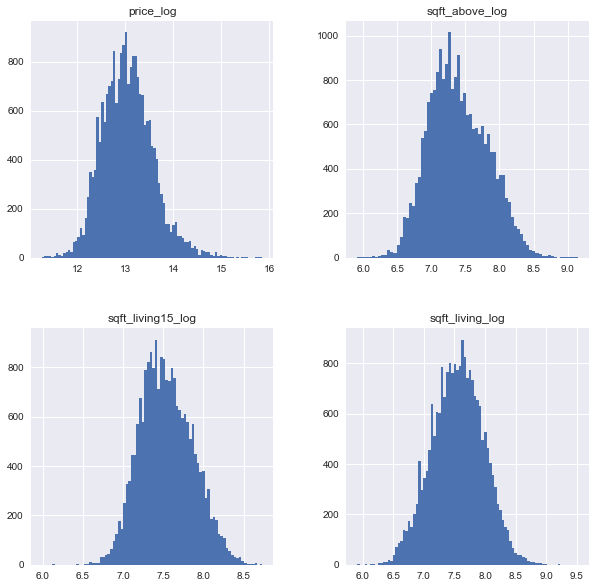

In [424]:
# plot log transformed histograms
df_log.hist(figsize=(10, 10), bins='auto');

In [425]:
# compare skew pre- and post-log
display(df[['price', 'sqft_living', 'sqft_above', 'sqft_living15']].skew())
display(df_log.skew())

price            4.023365
sqft_living      1.473215
sqft_above       1.447434
sqft_living15    1.106875
dtype: float64

price_log            0.431004
sqft_living_log     -0.027362
sqft_above_log       0.259699
sqft_living15_log    0.205978
dtype: float64

`price`, `sqft_above`, `sqft_living15`, and `sqft_living` seem to have improved. So, we'll keep those and add them to the original dataframe.

In [426]:
# add log transformed features to main df
df = pd.concat([df, df_log], axis=1)

# admire our handywork
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,day_of_yr_sold,month_sold,price_log,sqft_living_log,sqft_above_log,sqft_living15_log
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0,98178,47.5112,-122.257,1340,5650,2014,286,10,12.309982,7.073270,7.073270,7.200425
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991,98125,47.7210,-122.319,1690,7639,2014,343,12,13.195614,7.851661,7.682482,7.432484
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0,98028,47.7379,-122.233,2720,8062,2015,56,2,12.100712,6.646391,6.646391,7.908387
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0,98136,47.5208,-122.393,1360,5000,2014,343,12,13.311329,7.580700,6.956545,7.215240
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0,98074,47.6168,-122.045,1800,7503,2015,49,2,13.142166,7.426549,7.426549,7.495542


## Convert Zero-Inflated to Binary

Since the zero-inflated are mostly zeroes, let's just convert them to 0's and 1's for now to see if there's any difference between the two possibilities: False and True. If there is a significant difference, we come back and dial in investigation a bit more to see if there's a significant relationship within the True category.

In [427]:
# get list of columns with median equal to zero
cols = df.columns[((df==0).median()==True)].to_list()
df[cols].median()

waterfront       0.0
view             0.0
sqft_basement    0.0
yr_renovated     0.0
dtype: float64

In [428]:
# get a df with just those features
df_binary = df[cols]

# add the selected features as binary to new df
for col in cols:
    df_binary[col + '_binary'] = (df[col] > 0) * 1

# drop original versions from main df
df.drop(columns=cols, inplace=True)

# add the new df to the main df
df = pd.concat([df, df_binary], axis=1)

# admire our handywork
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,day_of_yr_sold,month_sold,price_log,sqft_living_log,sqft_above_log,sqft_living15_log,waterfront,view,sqft_basement,yr_renovated,waterfront_binary,view_binary,sqft_basement_binary,yr_renovated_binary
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,98178,47.5112,-122.257,1340,5650,2014,286,10,12.309982,7.073270,7.073270,7.200425,0.0,0.0,0.0,0,0,0,0,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,98125,47.7210,-122.319,1690,7639,2014,343,12,13.195614,7.851661,7.682482,7.432484,0.0,0.0,400.0,1991,0,0,1,1
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,98028,47.7379,-122.233,2720,8062,2015,56,2,12.100712,6.646391,6.646391,7.908387,0.0,0.0,0.0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,98136,47.5208,-122.393,1360,5000,2014,343,12,13.311329,7.580700,6.956545,7.215240,0.0,0.0,910.0,0,0,0,1,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,98074,47.6168,-122.045,1800,7503,2015,49,2,13.142166,7.426549,7.426549,7.495542,0.0,0.0,0.0,0,0,0,0,0


# Export Cleaned Data

In [429]:
# one last look at our handywork
display(df.describe(), df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 32 columns):
id                      21597 non-null int64
date                    21597 non-null datetime64[ns]
price                   21597 non-null float64
bedrooms                21597 non-null int64
bathrooms               21597 non-null float64
sqft_living             21597 non-null int64
sqft_lot                21597 non-null int64
floors                  21597 non-null float64
condition               21597 non-null int64
grade                   21597 non-null int64
sqft_above              21597 non-null int64
yr_built                21597 non-null int64
zipcode                 21597 non-null int64
lat                     21597 non-null float64
long                    21597 non-null float64
sqft_living15           21597 non-null int64
sqft_lot15              21597 non-null int64
yr_sold                 21597 non-null int64
day_of_yr_sold          21597 non-null int64
month_sold       

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,day_of_yr_sold,month_sold,price_log,sqft_living_log,sqft_above_log,sqft_living15_log,waterfront,view,sqft_basement,yr_renovated,waterfront_binary,view_binary,sqft_basement_binary,yr_renovated_binary
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.00000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,3.409825,7.657915,1788.596842,1970.999676,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,2014.322962,184.300042,6.573969,13.048211,7.550720,7.395148,7.539494,0.006760,0.233181,285.716581,68.758207,0.006760,0.097791,0.38510,0.034449
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.650546,1.173200,827.759761,29.375234,53.513072,0.138552,0.140724,685.230472,27274.441950,0.467619,94.737427,3.115061,0.526555,0.424191,0.427140,0.327467,0.081944,0.764673,439.819830,364.037499,0.081944,0.297039,0.48663,0.182384
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,3.000000,370.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,2.000000,1.000000,11.264464,5.913503,5.913503,5.988961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,2014.000000,110.000000,4.000000,12.682307,7.265430,7.081709,7.306531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,2014.000000,178.000000,6.000000,13.017003,7.554859,7.352441,7.517521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,2015.000000,262.000000,9.000000,13.377006,7.843849,7.700748,7.766417,0.000000,0.000000,550.000000,0.000000,0.000000,0.000000,1.00000,0.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,365.000000,12.000000,15.856731,9.513404,9.149528,8.733916,1.000000,4.000000,4820.000000,2015.000000,1.000000,1.000000,1.00000,1.000000


None

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,day_of_yr_sold,month_sold,price_log,sqft_living_log,sqft_above_log,sqft_living15_log,waterfront,view,sqft_basement,yr_renovated,waterfront_binary,view_binary,sqft_basement_binary,yr_renovated_binary
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,98178,47.5112,-122.257,1340,5650,2014,286,10,12.309982,7.073270,7.073270,7.200425,0.0,0.0,0.0,0,0,0,0,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,98125,47.7210,-122.319,1690,7639,2014,343,12,13.195614,7.851661,7.682482,7.432484,0.0,0.0,400.0,1991,0,0,1,1
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,98028,47.7379,-122.233,2720,8062,2015,56,2,12.100712,6.646391,6.646391,7.908387,0.0,0.0,0.0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,98136,47.5208,-122.393,1360,5000,2014,343,12,13.311329,7.580700,6.956545,7.215240,0.0,0.0,910.0,0,0,0,1,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,98074,47.6168,-122.045,1800,7503,2015,49,2,13.142166,7.426549,7.426549,7.495542,0.0,0.0,0.0,0,0,0,0,0


Everything looks as it should. Let's export it and begin our Exploratory Data Analysis.

In [430]:
# pickle results
with open('../databases/df-cleaned.pickle', 'wb') as f:
    # Pickle the 'df' dataframe using the highest protocol available.
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)